# Sarcasm Detection using Machine Learning

#### Goal of This File:

##### 1. Import Libraries, Helper Functions, and Constants ==> Data Sourcing and Munging ==> Utility Functions ==> Loading the Data ==> Merging all Individual Files

##### 2. Word Embeddings 

##### 3. Machine Learning Models ==> Small Model Test

##### 4. Conclusion ==> Results

## 1. Import Libraries, Helper Functions and Load Constants

In [104]:
!pip install pandas numpy nltk scikit-learn wordcloud\
seaborn gensim tensorflow imblearn xgboost matplotlib unrar pyunpack more-itertools patool > /dev/null

The system cannot find the path specified.


In [105]:
VAST = False

if VAST:
    !sudo apt-get install unrar
    !sudo apt-get install rar

GDRIVE = False

In [106]:
UTILS_URL = 'https://f005.backblazeb2.com/file/gp-support-files/archived_nlp_ai_utils.py'
UPDATING_VALUES_URL = 'https://f005.backblazeb2.com/file/gp-support-files/archived_updating_values.py'
ALL_LIBS_URL = 'https://f005.backblazeb2.com/file/gp-support-files/archived_all_libs_dl.py'
CHUNKS_URLS_FILE_URL = 'https://f005.backblazeb2.com/file/gp-support-files/chunks_urls.py'

UTILS_FILE_NAME = 'archived_nlp_ai_utils'
UPDATING_VALUES_FILE_NAME = 'archived_updating_values'
ALL_LIBS_FILE_NAME = 'archived_all_libs_dl'
CHUNKS_URLS_FILE_NAME = 'chunks_urls'

DEP_FILE_EXT = '.py'

In [107]:
import requests
import os

def get_dependencies(url,file_name,file_extension):
    if os.path.exists(file_name + file_extension):
        return print(file_name + " already exists.")
    else:
        print(f"downloading {file_name}...")
        r = requests.get(url)
        with open(file_name + file_extension, 'wb') as fd:
            for chunk in r.iter_content():
                fd.write(chunk)

In [108]:
get_dependencies(UTILS_URL,UTILS_FILE_NAME,DEP_FILE_EXT)
get_dependencies(UPDATING_VALUES_URL,UPDATING_VALUES_FILE_NAME,DEP_FILE_EXT)
get_dependencies(ALL_LIBS_URL,ALL_LIBS_FILE_NAME,DEP_FILE_EXT)
get_dependencies(CHUNKS_URLS_FILE_URL,CHUNKS_URLS_FILE_NAME,DEP_FILE_EXT)

archived_nlp_ai_utils already exists.
archived_updating_values already exists.
archived_all_libs_dl already exists.
chunks_urls already exists.


In [109]:
from archived_nlp_ai_utils import *
from chunks_urls import SD_CHUNKS_URLS
from archived_updating_values import *

In [110]:
TF_ENABLE_ONEDNN_OPTS = 0
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
DATA_URLS = SD_CHUNKS_URLS
LIMIT = SD_DATA_LIMIT
TRAINED_MODELS_COUNT = TRAINED_MODELS
if GDRIVE:
    DATASET_PATH = "datasets"
    PICKLES_DIR = "sd_pickle_files"
else:
    DATASET_PATH = "../datasets"
    PICKLES_DIR = "../sd_pickle_files"

PREPROCESSED_CHUNKS_PATH = DATASET_PATH + "/preprocessed_sd_data_chunks/"
BASE_FILE_NAME = "sd_chunk_"
FILE_FORMAT = ".csv"
DATA_IN_CHUNK = 99744
if LIMIT == 10:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT - 2
else:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT
RANDOM_STATE = CONST_RANDOM_STATE
np.random.seed(CONST_RANDOM_STATE)

USE_SUBSET = 10000
USE_PICKLES = False
PRINT_METRICS = True

### 1.1 Data Sourcing and Munging

#### 1.1.1 Loading The Data

In [111]:
DATASET_PATH

'../datasets'

In [112]:
PREPROCESSED_CHUNKS_PATH

'../datasets/preprocessed_sd_data_chunks/'

In [113]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(DATA_URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

sd_chunk_1 already exists.


#### 1.1.2 Merging all Individual Files

In [114]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [115]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [116]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [117]:
if USE_SUBSET:
    df = df[:USE_SUBSET]
    ACTUAL_DATA_SHAPE = USE_SUBSET

In [118]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

100.0

In [119]:
df.reset_index(inplace = True)
df.drop(['index'],axis = 1,inplace = True)

In [120]:
X = df['text']
y = df['labels']

In [121]:
X = pd.Series([str(text) for text in X])

y = pd.Series([int(label) for label in y])

In [122]:
if not os.path.exists(PICKLES_DIR):
    os.mkdir(PICKLES_DIR)

## 2. Word Embeddings

In [123]:
TRAIN_PERCENT = 0.8
VALID_TEST_PERCENT = 0.1
TRAIN_SIZE = int(ACTUAL_DATA_SHAPE * TRAIN_PERCENT)
VALID_TEST_SIZE = int(ACTUAL_DATA_SHAPE * VALID_TEST_PERCENT)
TOTAL_TEST_SIZE = TRAIN_SIZE + VALID_TEST_SIZE

### 2.1 Word2Vec

In [124]:
X_W2V = X

In [125]:
w2v_model = CountVectorizer()

train_set_w2v = w2v_model.fit_transform(X_W2V[:TRAIN_SIZE]).toarray()

validation_set_w2v = w2v_model.transform(X_W2V[TRAIN_SIZE:TOTAL_TEST_SIZE]).toarray()

test_set_w2v = w2v_model.transform(X_W2V[TOTAL_TEST_SIZE:]).toarray()

### 2.2 TF-IDF

In [126]:
X_TFIDF = X

In [127]:
tfidf_model = TfidfVectorizer()

train_set_tfidf = tfidf_model.fit_transform(X_TFIDF[:TRAIN_SIZE]).toarray()

validation_set_tfidf = tfidf_model.transform(X_TFIDF[TRAIN_SIZE:TOTAL_TEST_SIZE]).toarray()

test_set_tfidf = tfidf_model.transform(X_TFIDF[TOTAL_TEST_SIZE:]).toarray()

### 2.3 FastText

In [128]:
X_FT = X

In [129]:
ft_model = FastText(sentences=[nltk.word_tokenize(text) for text in X_FT], vector_size=100, window=5, min_count=1, workers=4)

In [130]:
word_index_ft = {}

for i, word in enumerate(ft_model.wv.key_to_index):
    word_index_ft[word] = i

In [131]:
vocab_size = len(word_index_ft)
embedding_dim_ft = ft_model.vector_size

embedding_matrix_ft = np.zeros((vocab_size, embedding_dim_ft))

for word, i in word_index_ft.items():
    if word in ft_model.wv.key_to_index:
        embedding_matrix_ft[i] = ft_model.wv.get_vector(word)

In [132]:
train_set_ft = embedding_matrix_ft[:TRAIN_SIZE]
validation_set_ft = embedding_matrix_ft[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_set_ft = embedding_matrix_ft[TOTAL_TEST_SIZE:]

## 3. Machine Learning Models

In [133]:
train_set_w2v = preprocessing.normalize(train_set_w2v)
validation_set_w2v = preprocessing.normalize(validation_set_w2v)
test_set_w2v = preprocessing.normalize(test_set_w2v)
train_set_tfidf = preprocessing.normalize(train_set_tfidf)
validation_set_tfidf = preprocessing.normalize(validation_set_tfidf)
test_set_tfidf = preprocessing.normalize(test_set_tfidf)
train_set_ft = preprocessing.normalize(train_set_ft)
validation_set_ft = preprocessing.normalize(validation_set_ft)
test_set_ft = preprocessing.normalize(test_set_ft)

In [134]:
sc = StandardScaler()
train_set_w2v = sc.fit_transform(train_set_w2v)
validation_set_w2v = sc.transform(validation_set_w2v)
test_set_w2v = sc.transform(test_set_w2v)
train_set_tfidf = sc.fit_transform(train_set_tfidf)
validation_set_tfidf = sc.transform(validation_set_tfidf)
test_set_tfidf = sc.transform(test_set_tfidf)
train_set_ft = sc.fit_transform(train_set_ft)
validation_set_ft = sc.transform(validation_set_ft)
test_set_ft = sc.transform(test_set_ft)

### 3.1 Word2Vec Train-Validation-Test Split

In [135]:
train_labels_w2v = y[:TRAIN_SIZE]
validation_labels_w2v = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_labels_w2v = y[TOTAL_TEST_SIZE:]

### 3.2 TF-IDF Train-Validation-Test Split

In [136]:
train_labels_tfidf = y[:TRAIN_SIZE]
validation_labels_tfidf = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_labels_tfidf = y[TOTAL_TEST_SIZE:]

### 3.3 FastText Train-Validation-Test Split

In [137]:
train_labels_ft = y[:TRAIN_SIZE]
validation_labels_ft = y[TRAIN_SIZE:TOTAL_TEST_SIZE]
test_labels_ft = y[TOTAL_TEST_SIZE:]

### 3.4 Naive Bayes

#### 3.4.1 Word2Vec 

In [138]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_nb' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    nb_clf_w2v = GaussianNB()
    nb_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_nb_w2v = nb_clf_w2v.predict(validation_set_w2v)
    nb_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_nb_w2v)
else:
    print("Found Pickle File.")

Training Model...


#### 3.4.2 TF-IDF 

In [139]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_nb' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    nb_clf_tfidf = GaussianNB()
    nb_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_nb_tfidf = nb_clf_tfidf.predict(validation_set_tfidf)
    nb_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_nb_tfidf)
else:
    print("Found Pickle File.")

Training Model...


#### 3.4.3 FastText

In [140]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_nb' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    nb_clf_ft = GaussianNB()
    nb_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_nb_ft = nb_clf_ft.predict(validation_set_ft)
    nb_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_nb_ft)
else:
    print("Found Pickle File.")

Training Model...


### 3.5 lr

#### 3.5.1 Word2Vec 

In [141]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_lr' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    lr_clf_w2v = LogisticRegression(random_state=RANDOM_STATE)
    lr_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_lr_w2v = lr_clf_w2v.predict(validation_set_w2v)
    lr_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_lr_w2v)
else:
    print("Found Pickle File.")

Training Model...


#### 3.5.2 TF-IDF 

In [142]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_lr' + '.pickle') or not USE_PICKLES:
    lr_clf_tfidf = LogisticRegression(random_state=RANDOM_STATE)
    lr_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_lr_tfidf = lr_clf_tfidf.predict(validation_set_tfidf)
    lr_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_lr_tfidf)
else:
    print("Found Pickle File.")

#### 3.5.3 FastText

In [143]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_lr' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    lr_clf_ft = LogisticRegression(random_state=RANDOM_STATE)
    lr_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_lr_ft = lr_clf_ft.predict(validation_set_ft)
    lr_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_lr_ft)
else:
    print("Found Pickle File.")

Training Model...


### 3.6 Random Forest

#### 3.6.1 Word2Vec

In [144]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_rf' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    rf_clf_w2v = RandomForestClassifier(n_estimators=50,random_state=RANDOM_STATE)
    rf_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_rf_w2v = rf_clf_w2v.predict(validation_set_w2v)
    rf_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_rf_w2v)
else:
    print("Found Pickle File.")

Training Model...


#### 3.6.2 TF-IDF

In [145]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_rf' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    rf_clf_tfidf = RandomForestClassifier(n_estimators=50,random_state=RANDOM_STATE)
    rf_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_rf_tfidf = rf_clf_tfidf.predict(validation_set_tfidf)
    rf_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_rf_tfidf)
else:
    print("Found Pickle File.")

Training Model...


#### 3.6.3 FastText

In [146]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_rf' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    rf_clf_ft = RandomForestClassifier(n_estimators=50,random_state=RANDOM_STATE)
    rf_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_rf_ft = rf_clf_ft.predict(validation_set_ft)
    rf_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_rf_ft)
else:
    print("Found Pickle File.")

Training Model...


### 3.7 XGBoost

#### 3.7.1 Word2Vec

In [147]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_xgb' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    xgb_clf_w2v = XGBClassifier(random_state=RANDOM_STATE)
    xgb_clf_w2v.fit(train_set_w2v, train_labels_w2v)
    validation_predictions_xgb_w2v = xgb_clf_w2v.predict(validation_set_w2v)
    xgb_w2v_accuracy = metrics.accuracy_score(validation_labels_w2v,validation_predictions_xgb_w2v)
else:
    print("Found Pickle File.")

Training Model...


#### 3.7.2 TF-IDF

In [148]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_xgb' + '.pickle') or not USE_PICKLES:
    xgb_clf_tfidf = XGBClassifier(random_state=RANDOM_STATE)
    xgb_clf_tfidf.fit(train_set_tfidf, train_labels_tfidf)
    validation_predictions_xgb_tfidf = xgb_clf_tfidf.predict(validation_set_tfidf)
    xgb_tfidf_accuracy = metrics.accuracy_score(validation_labels_tfidf,validation_predictions_xgb_tfidf)
else:
    print("Found Pickle File.")

#### 3.7.3 FastText

In [149]:
if not os.path.exists(PICKLES_DIR + '/' + 'all_xgb' + '.pickle') or not USE_PICKLES:
    print("Training Model...")
    xgb_clf_ft = XGBClassifier(random_state=RANDOM_STATE)
    xgb_clf_ft.fit(train_set_ft, train_labels_ft)
    validation_predictions_xgb_ft = xgb_clf_ft.predict(validation_set_ft)
    xgb_ft_accuracy = metrics.accuracy_score(validation_labels_ft,validation_predictions_xgb_ft)
else:
    print("Found Pickle File.")

Training Model...


### 3.8 Small Model Test

In [150]:
def test_model(sentence,embedding,clf):
    test_token = nltk.word_tokenize(sentence)
    test_vector = np.zeros(embedding.vector_size)
    for word in test_token:
        if word in embedding.wv:
            test_vector += embedding.wv[word]
    test_vector /= len(test_token)
    predicted_label = clf.predict([test_vector])[0]
    return predicted_label

#### 3.9 Save Models

In [151]:
if USE_PICKLES:
    all_models = []

In [152]:
if os.path.exists(PICKLES_DIR + '/' + "all_nb.pickle"):
    if USE_PICKLES:
        print("Found Pickle File for nb.")
        all_nb = pickle.load(open(PICKLES_DIR + '/' + 'all_nb.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_nb' + '.pickle','wb')
    nb_dict = {'nb_clf_w2v':nb_clf_w2v,'nb_clf_w2v_preds':validation_predictions_nb_w2v,'nb_clf_tfidf':nb_clf_tfidf,\
        'nb_clf_tfidf_preds':validation_predictions_nb_tfidf,'nb_clf_ft':nb_clf_ft,'nb_clf_ft_preds':validation_predictions_nb_ft,}
    pickle.dump(nb_dict,pickle_out)
    pickle_out.close()
    all_nb = nb_dict
    print("Created Pickle File for nb.")
    
if USE_PICKLES:
    all_models.append(all_nb)

In [153]:
if os.path.exists(PICKLES_DIR + '/' + "all_lr.pickle"):
    if USE_PICKLES:
        print("Found Pickle File for lr.")
        all_lr = pickle.load(open(PICKLES_DIR + '/' + 'all_lr.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_lr' + '.pickle','wb')
    lr_dict = {'lr_clf_w2v':lr_clf_w2v,'lr_clf_w2v_preds':validation_predictions_lr_w2v,'lr_clf_tfidf':lr_clf_tfidf,\
        'lr_clf_tfidf_preds':validation_predictions_lr_tfidf,'lr_clf_ft':lr_clf_ft,'lr_clf_ft_preds':validation_predictions_lr_ft}
    pickle.dump(lr_dict,pickle_out)
    pickle_out.close()
    all_lr = lr_dict
    print("Created Pickle File for lr.")

if USE_PICKLES:
    all_models.append(all_lr)

In [154]:
if os.path.exists(PICKLES_DIR + '/' + "all_rf.pickle"):
    if USE_PICKLES:
        print("Found Pickle File for rf.")
        all_rf = pickle.load(open(PICKLES_DIR + '/' + 'all_rf.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_rf' + '.pickle','wb')
    rf_dict = {'rf_clf_w2v':rf_clf_w2v,'rf_clf_w2v_preds':validation_predictions_rf_w2v,'rf_clf_tfidf':rf_clf_tfidf,\
        'rf_clf_tfidf_preds':validation_predictions_rf_tfidf,'rf_clf_ft':rf_clf_ft,'rf_clf_ft_preds':validation_predictions_rf_ft}
    pickle.dump(rf_dict,pickle_out)
    pickle_out.close()
    all_rf = rf_dict
    print("Created Pickle File for rf.")
    
if USE_PICKLES:
    all_models.append(all_rf)

In [155]:
if os.path.exists(PICKLES_DIR + "/" + "all_xgb.pickle"):
    if USE_PICKLES:
        print("Found Pickle File for xgb.")
        all_xgb = pickle.load(open(PICKLES_DIR + '/' + 'all_xgb.pickle','rb'))
else:
    pickle_out = open(PICKLES_DIR + '/' + 'all_xgb' + '.pickle','wb')
    xgb_dict = {'xgb_clf_w2v':xgb_clf_w2v,'xgb_clf_w2v_preds':validation_predictions_xgb_w2v,'xgb_clf_tfidf':xgb_clf_tfidf,\
        'xgb_clf_tfidf_preds':validation_predictions_xgb_tfidf,'xgb_clf_ft':xgb_clf_ft,'xgb_clf_ft_preds':validation_predictions_xgb_ft,}
    pickle.dump(xgb_dict,pickle_out)
    pickle_out.close()
    all_xgb = xgb_dict
    print("Created Pickle File for xgb.")
    
if USE_PICKLES:    
    all_models.append(all_xgb)

## 4. Conclusion

### 4.1 Results

### DISCLAIMER: VISUALIZATIONS CAN TAKE A WHILE TO RUN. IF YOU DO NOT WANT TO WAIT A LONG TIME TO RUN THE WHOLE FILE, SET THE "PRINT_METRICS" FLAG TO FALSE.

In [161]:
len(embedding_matrix_ft)

14271

In [160]:
len(y)

10000

PRINTING METRICS FOR Gaussian Naive Bayes/Word2Vec


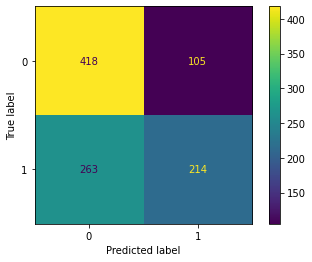

ROC/AUC: 
{0: 0.6239362491031022, 1: 0.6239362491031022}


Classification Report = 
                precision    recall  f1-score   support

           0       0.61      0.80      0.69       523
           1       0.67      0.45      0.54       477

    accuracy                           0.63      1000
   macro avg       0.64      0.62      0.62      1000
weighted avg       0.64      0.63      0.62      1000



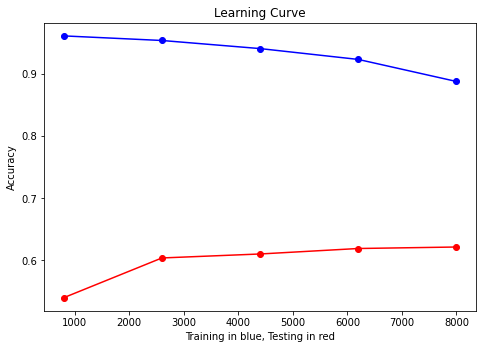

PRINTING METRICS FOR Gaussian Naive Bayes/TFIDF


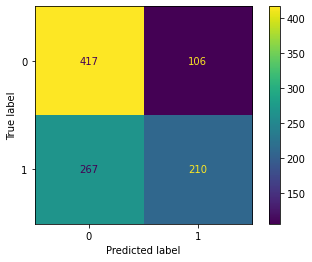

ROC/AUC: 
{0: 0.618787354041151, 1: 0.6187873540411511}


Classification Report = 
                precision    recall  f1-score   support

           0       0.61      0.80      0.69       523
           1       0.66      0.44      0.53       477

    accuracy                           0.63      1000
   macro avg       0.64      0.62      0.61      1000
weighted avg       0.64      0.63      0.61      1000



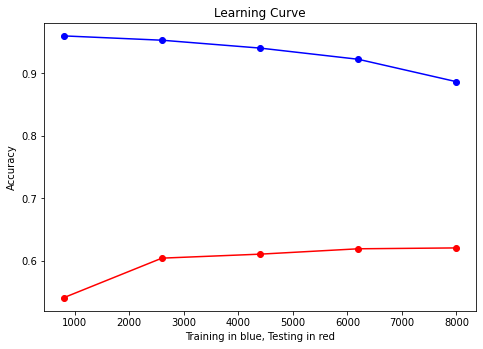

PRINTING METRICS FOR Gaussian Naive Bayes/FastText


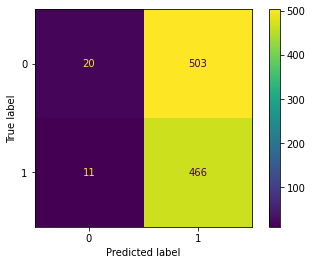

ROC/AUC: 
{0: 0.5075900605681624, 1: 0.5075900605681622}


Classification Report = 
                precision    recall  f1-score   support

           0       0.65      0.04      0.07       523
           1       0.48      0.98      0.64       477

    accuracy                           0.49      1000
   macro avg       0.56      0.51      0.36      1000
weighted avg       0.57      0.49      0.35      1000



ValueError: Found input variables with inconsistent numbers of samples: [14271, 10000]

In [156]:
if PRINT_METRICS:
    if USE_PICKLES:
        show_metrics('Gaussian Naive Bayes/Word2Vec',all_models[0]['nb_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[0]['nb_clf_w2v_preds'],\
                    np.concatenate([train_set_w2v,validation_set_w2v,test_set_w2v]),y,5)
        show_metrics('Gaussian Naive Bayes/TFIDF',all_models[0]['nb_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[0]['nb_clf_tfidf_preds'],\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('Gaussian Naive Bayes/FastText',all_models[0]['nb_clf_ft'],validation_set_ft,validation_labels_ft,all_models[0]['nb_clf_ft_preds'],\
                    np.concatenate([train_set_ft,validation_set_ft,test_set_ft]),y,5)
        
    else:
        show_metrics('Gaussian Naive Bayes/Word2Vec',nb_clf_w2v,validation_set_w2v,validation_labels_w2v,validation_predictions_nb_w2v,\
                    np.concatenate([train_set_w2v,validation_set_w2v,test_set_w2v]),y,5)
        show_metrics('Gaussian Naive Bayes/TFIDF',nb_clf_tfidf,validation_set_tfidf,validation_labels_tfidf,validation_predictions_nb_tfidf,\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('Gaussian Naive Bayes/FastText',nb_clf_ft,validation_set_ft,validation_labels_ft,validation_predictions_nb_ft,\
                    np.concatenate([train_set_ft,validation_set_ft,test_set_ft]),y,5)

PRINTING METRICS FOR Logistic Regression/Word2Vec


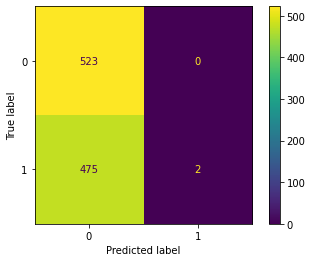

ROC/AUC: 
{0: 0.5020964360587001, 1: 0.5020964360587002}


Classification Report = 
                precision    recall  f1-score   support

           0       0.52      1.00      0.69       523
           1       1.00      0.00      0.01       477

    accuracy                           0.53      1000
   macro avg       0.76      0.50      0.35      1000
weighted avg       0.75      0.53      0.36      1000



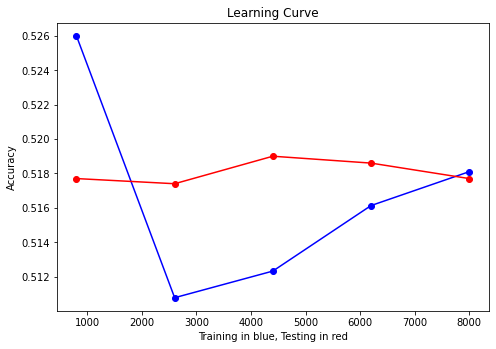

PRINTING METRICS FOR Logistic Regression/TFIDF


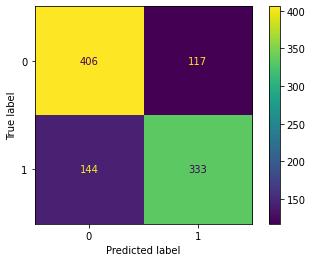

ROC/AUC: 
{0: 0.7372019192611566, 1: 0.7372019192611566}


Classification Report = 
                precision    recall  f1-score   support

           0       0.74      0.78      0.76       523
           1       0.74      0.70      0.72       477

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



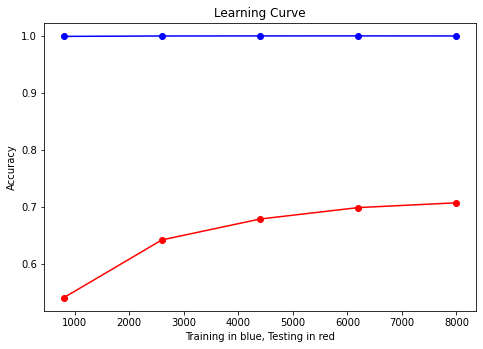

PRINTING METRICS FOR Logistic Regression/FastText


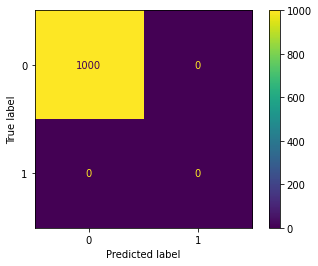

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
if PRINT_METRICS:
    if USE_PICKLES:
        show_metrics('Logistic Regression/Word2Vec',all_models[1]['lr_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[1]['lr_clf_w2v_preds'],\
                    np.concatenate([train_set_w2v,validation_set_w2v,test_set_w2v]),y,5)
        show_metrics('Logistic Regression/TFIDF',all_models[1]['lr_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[1]['lr_clf_tfidf_preds'],\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('Logistic Regression/FastText',all_models[1]['lr_clf_ft'],validation_set_ft,validation_labels_ft,all_models[1]['lr_clf_ft_preds'],\
                    np.concatenate([train_set_ft,validation_set_ft,test_set_ft]),y,5)

    else:
        show_metrics('Logistic Regression/Word2Vec',lr_clf_w2v,validation_set_w2v,validation_labels_w2v,validation_predictions_lr_w2v,\
                    np.concatenate([train_set_w2v,validation_set_w2v,test_set_w2v]),y,5)
        show_metrics('Logistic Regression/TFIDF',lr_clf_tfidf,validation_set_tfidf,validation_labels_tfidf,validation_predictions_lr_tfidf,\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('Logistic Regression/FastText',lr_clf_ft,validation_set_ft,validation_predictions_lr_ft,\
                    np.concatenate([train_set_ft,validation_set_ft,test_set_ft]),y,5)

In [ ]:
if PRINT_METRICS:
    if USE_PICKLES:
        show_metrics('Random Forest/Word2Vec',all_models[2]['rf_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[2]['rf_clf_w2v_preds'],X_W2V,y,5)
        show_metrics('Random Forest/TFIDF',all_models[2]['rf_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[2]['rf_clf_tfidf_preds'],\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('Random Forest/FastText',all_models[2]['rf_clf_ft'],validation_set_ft,validation_labels_ft,all_models[2]['rf_clf_ft_preds'],X_FT,y,5)

    else:
        show_metrics('Random Forest/Word2Vec',rf_clf_w2v,validation_set_w2v,validation_labels_w2v,validation_predictions_rf_w2v,\
                    np.concatenate([train_set_w2v,validation_set_w2v,test_set_w2v]),y,5)
        show_metrics('Random Forest/TFIDF',rf_clf_tfidf,validation_set_tfidf,validation_labels_tfidf,validation_predictions_rf_tfidf,\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('Random Forest/FastText',rf_clf_ft,validation_set_ft,validation_labels_ft,validation_predictions_rf_ft,\
                    np.concatenate([train_set_ft,validation_set_ft,test_set_ft]),y,5)

In [ ]:
if PRINT_METRICS:
    if USE_PICKLES:
        show_metrics('XGBoost/Word2Vec',all_models[3]['xgb_clf_w2v'],validation_set_w2v,validation_labels_w2v,all_models[3]['xgb_clf_w2v_preds'],X_W2V,y,5)
        show_metrics('XGBoost/TFIDF',all_models[3]['xgb_clf_tfidf'],validation_set_tfidf,validation_labels_tfidf,all_models[3]['xgb_clf_tfidf_preds'],\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('XGBoost/FastText',all_models[3]['xgb_clf_ft'],validation_set_ft,validation_labels_ft,all_models[3]['xgb_clf_ft_preds'],X_FT,y,5)

    else:
        show_metrics('XGBoost/Word2Vec',xgb_clf_w2v,validation_set_w2v,validation_labels_w2v,validation_predictions_xgb_w2v,\
                    np.concatenate([train_set_w2v,validation_set_w2v,test_set_w2v]),y,5)
        show_metrics('XGBoost/TFIDF',xgb_clf_tfidf,validation_set_tfidf,validation_labels_tfidf,validation_predictions_xgb_tfidf,\
                    np.concatenate([train_set_tfidf,validation_set_tfidf,test_set_tfidf]),y,5)
        show_metrics('XGBoost/FastText',xgb_clf_ft,validation_set_ft,validation_labels_ft,validation_predictions_xgb_ft,\
                    np.concatenate([train_set_ft,validation_set_ft,test_set_ft]),y,5)